<a href="https://colab.research.google.com/github/sakshamhooda/PneumoniaDetection/blob/main/main_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up kaggle for colab

In [ ]:
!pip install kaggle

In [ ]:
# Step 1: Install Kaggle API
!pip install kaggle

# Step 2: Upload kaggle.json
from google.colab import files
files.upload()  # Upload the kaggle.json file

# Step 3: Move kaggle.json to the correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Step 4: Set permissions
!chmod 600 ~/.kaggle/kaggle.json

# Step 5: Verify Kaggle API setup
!kaggle competitions list

# Step 6: Accept competition rules manually on Kaggle website

# Step 7: Download the competition data
!kaggle competitions download -c 123-of-ai-presents-pneumonia-detection-from-xray

# Step 8: Unzip the data
!unzip 123-of-ai-presents-pneumonia-detection-from-xray.zip -d data/

# Step 9: Verify the files
!ls data/


Streaming output truncated to the last 5000 lines.
  inflating: data/processed_train_data/img550.jpeg  
  inflating: data/processed_train_data/img5500.jpg  
  inflating: data/processed_train_data/img5501.jpg  
  inflating: data/processed_train_data/img5502.jpg  
  inflating: data/processed_train_data/img5503.jpg  
  inflating: data/processed_train_data/img5504.jpg  
  inflating: data/processed_train_data/img5505.jpg  
  inflating: data/processed_train_data/img5506.jpg  
  inflating: data/processed_train_data/img5507.jpg  
  inflating: data/processed_train_data/img5508.jpg  
  inflating: data/processed_train_data/img5509.jpg  
  inflating: data/processed_train_data/img551.jpeg  
  inflating: data/processed_train_data/img5510.jpg  
  inflating: data/processed_train_data/img5511.jpg  
  inflating: data/processed_train_data/img5512.jpg  
  inflating: data/processed_train_data/img5513.jpg  
  inflating: data/processed_train_data/img5514.jpg  
  inflating: data/processed_train_data/img5515.j

# Approach

1. Understanding the Dataset

Directories and Files:

processed_train_set/: Contains the training X-ray images.
processed_test_set/: Contains the test X-ray images.
train_metadata.csv: Contains mappings of image names to their classes (healthy or pneumonia).
test_files.csv: Contains the list of test image names.
sample_submission.csv: A sample submission file.
Data Columns:

path: The image file name.
class: The ground truth label (healthy or pneumonia).
2. Data Preparation

Load train_metadata.csv and test_files.csv.
Ensure that the image paths and labels are correctly mapped.
Use appropriate data generators that match the dataset structure.
3. Model Selection

Use Inception V3 as the base model with ImageNet weights.
If desired, ensemble with EfficientNetB0 for improved performance.
4. Training Strategy

Freeze the base model layers initially and train the top layers.
Unfreeze some layers for fine-tuning.
Use data augmentation to prevent overfitting.
Monitor the F1 score, as per the competition metric.
5. Evaluation and Submission

Evaluate the model on a validation set.
Generate predictions on the test set.
Prepare the submission file matching the required format.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import f1_score

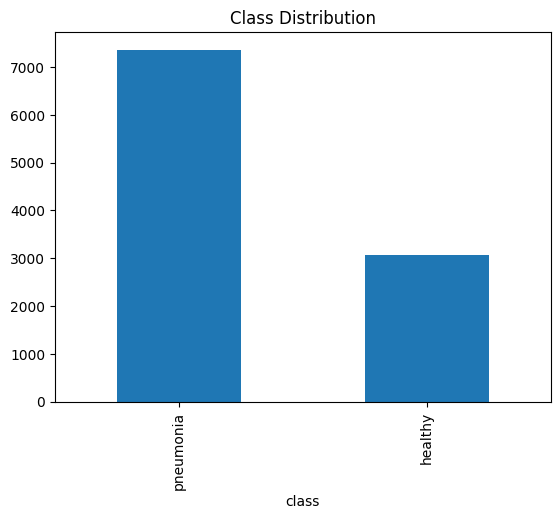

In [ ]:
# Load the dataframes
train_df = pd.read_csv('/content/data/1. train_metadata.csv')
test_df = pd.read_csv('/content/data/2. test_files.csv')

# Display class distribution
train_df['class'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()


In [ ]:
# Add full path to image files
train_df['path'] = '/content/data/processed_test_set/' + train_df['path']
test_df['path'] = '/content/data/processed_test_set/' + test_df['path']


In [ ]:
print(train_df.head())


                                             path      class
0   /content/data/processed_test_set/img8223.jpeg  pneumonia
1    /content/data/processed_test_set/img4325.jpg  pneumonia
2    /content/data/processed_test_set/img6532.jpg  pneumonia
3  /content/data/processed_test_set/img10118.jpeg  pneumonia
4   /content/data/processed_test_set/img9961.jpeg  pneumonia


In [ ]:
missing_files = train_df[~train_df['path'].apply(os.path.exists)]
print(f"Missing files:\n{missing_files}")

Missing files:
                                                 path      class
0       /content/data/processed_test_set/img8223.jpeg  pneumonia
1        /content/data/processed_test_set/img4325.jpg  pneumonia
2        /content/data/processed_test_set/img6532.jpg  pneumonia
3      /content/data/processed_test_set/img10118.jpeg  pneumonia
4       /content/data/processed_test_set/img9961.jpeg  pneumonia
...                                               ...        ...
10419   /content/data/processed_test_set/img2969.jpeg    healthy
10420    /content/data/processed_test_set/img2017.jpg    healthy
10424    /content/data/processed_test_set/img1536.jpg    healthy
10425   /content/data/processed_test_set/img2986.jpeg    healthy
10426    /content/data/processed_test_set/img945.jpeg    healthy

[9540 rows x 2 columns]


In [ ]:
# Define the image size and batch size
IMAGE_SIZE = (299, 299)  # InceptionV3 default size
BATCH_SIZE = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.2  # 20% for validation
)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Create training and validation generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='class',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='class',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Create test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)


Found 712 validated image filenames belonging to 1 classes.
Found 177 validated image filenames belonging to 1 classes.
Found 1928 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 9540 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 9540 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Load InceptionV3 with pre-trained ImageNet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))


In [ ]:
# Add global average pooling and output layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Early stopping to prevent overfitting
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model
checkpoint = ModelCheckpoint('inception_v3_best_model.keras', monitor='val_loss', save_best_only=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-7)

callbacks = [earlystop, checkpoint, reduce_lr]


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 276s 11s/step - accuracy: 0.7840 - loss: 0.3632 - val_accuracy: 1.0000 - val_loss: 8.7730e-04 - learning_rate: 0.0010
Epoch 2/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:48 8s/step - accuracy: 1.0000 - loss: 7.6575e-04

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 294ms/step - accuracy: 1.0000 - loss: 7.6575e-04 - val_accuracy: 1.0000 - val_loss: 5.3979e-04 - learning_rate: 0.0010
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 289s 13s/step - accuracy: 1.0000 - loss: 7.5271e-04 - val_accuracy: 1.0000 - val_loss: 3.3836e-04 - learning_rate: 0.0010
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - accuracy: 1.0000 - loss: 4.6264e-04 - val_accuracy: 1.0000 - val_loss: 3.6679e-04 - learning_rate: 0.0010
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 242s 11s/step - accuracy: 1.0000 - loss: 3.5193e-04 - val_accuracy: 1.0000 - val_loss: 2.7703e-04 - learning_rate: 0.0010
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 1.0000 - loss: 3.0596e-04 - val_accuracy: 1.0000 - val_loss: 2.8766e-04 - learning_rate: 0.0010
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 245s 11s/step - accuracy: 1.0000 - loss: 3.3453e-04 - val_accuracy: 1.0000 - val_loss: 2.9671e-04 - learning_rate: 2.0000e-04
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/st

**Fine-Tuning**

In [ ]:
# Unfreeze the top 50 layers of the model
for layer in base_model.layers[-50:]:
    layer.trainable = True


In [ ]:
# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 261s 11s/step - accuracy: 1.0000 - loss: 2.9730e-04 - val_accuracy: 1.0000 - val_loss: 2.5838e-04 - learning_rate: 1.0000e-05
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 270ms/step - accuracy: 1.0000 - loss: 2.1066e-04 - val_accuracy: 1.0000 - val_loss: 2.0425e-04 - learning_rate: 1.0000e-05
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 238s 10s/step - accuracy: 1.0000 - loss: 3.0191e-04 - val_accuracy: 1.0000 - val_loss: 2.2131e-04 - learning_rate: 1.0000e-05
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step - accuracy: 1.0000 - loss: 1.5675e-04 - val_accuracy: 1.0000 - val_loss: 1.6453e-04 - learning_rate: 1.0000e-05
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 256s 11s/step - accuracy: 1.0000 - loss: 2.6369e-04 - val_accuracy: 1.0000 - val_loss: 1.9197e-04 - learning_rate: 2.0000e-06


**Evaluation**

In [ ]:
# Reset validation generator and get predictions
validation_generator.reset()
val_preds = model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE + 1)
val_preds = (val_preds > 0.5).astype(int).reshape(-1)


6/6 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step


In [ ]:
# True labels
val_labels = validation_generator.classes


In [ ]:
from sklearn.metrics import f1_score

# Calculate F1 score
val_f1 = f1_score(val_labels, val_preds)
print('Validation F1 Score:', val_f1)


Validation F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Generate Predictions on Test Set**

In [ ]:
# Predict on the test set
test_generator.reset()
test_preds = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
test_preds = (test_preds > 0.5).astype(int).reshape(-1)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 515s 8s/step


In [ ]:
# Get the mapping from class indices to labels
class_indices = train_generator.class_indices
reverse_class_indices = {v: k for k, v in class_indices.items()}

# Map predictions to class names
test_labels = [reverse_class_indices[pred] for pred in test_preds]


In [ ]:
# Prepare submission DataFrame
submission = pd.DataFrame({
    'ID': test_df['path'].apply(lambda x: os.path.basename(x)),
    'class': test_labels
})

# Ensure it matches the sample submission format
submission = submission[['ID', 'class']]
submission.columns = ['path', 'class']

# Save to CSV
submission.to_csv('submission.csv', index=False)
